In [26]:
import pandas as pd
from pyspark.sql import SparkSession
from sqlalchemy import create_engine
import pandasql as ps
import os
from urllib.parse import quote_plus
from plotly import graph_objects as go

import plotly.express as px
import warnings

In [12]:
extraClassPath = ''
jarsPath = ''

In [13]:
spark = SparkSession.builder\
                    .master("local")\
                    .appName("DAILendingPoolOverview")\
                    .config("spark.jars", jarsPath)\
                    .config('spark.executor.extraClassPath', extraClassPath)\
                    .config("spark.executor.heartbeatInterval", "3600s")\
                    .config("spark.network.timeout", "10000s")\
                    .getOrCreate()

In [14]:
spark

In [15]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

In [16]:
db_address = os.getenv('DB_ADDRESS', '')
db_user = os.getenv('DB_USER', '')
db_password = quote_plus(os.getenv('DB_PASSWORD', ''))
db_name = os.getenv('DB_NAME', '')

In [17]:
db_url = f'postgresql://{db_user}:{db_password}@{db_address}/{db_name}'
db_engine = create_engine(db_url)

# EDA

> In those samples of code we will concentrate analytics on **DAI** lending pool on [Aave](https://app.aave.com/markets/), but the current ETL Architecture may provide more flexible configuration such as web-UI with dynamic variables to choose certain chain, protocol and pool for analysis, for example on the same [Aave](https://app.aave.com/markets/)

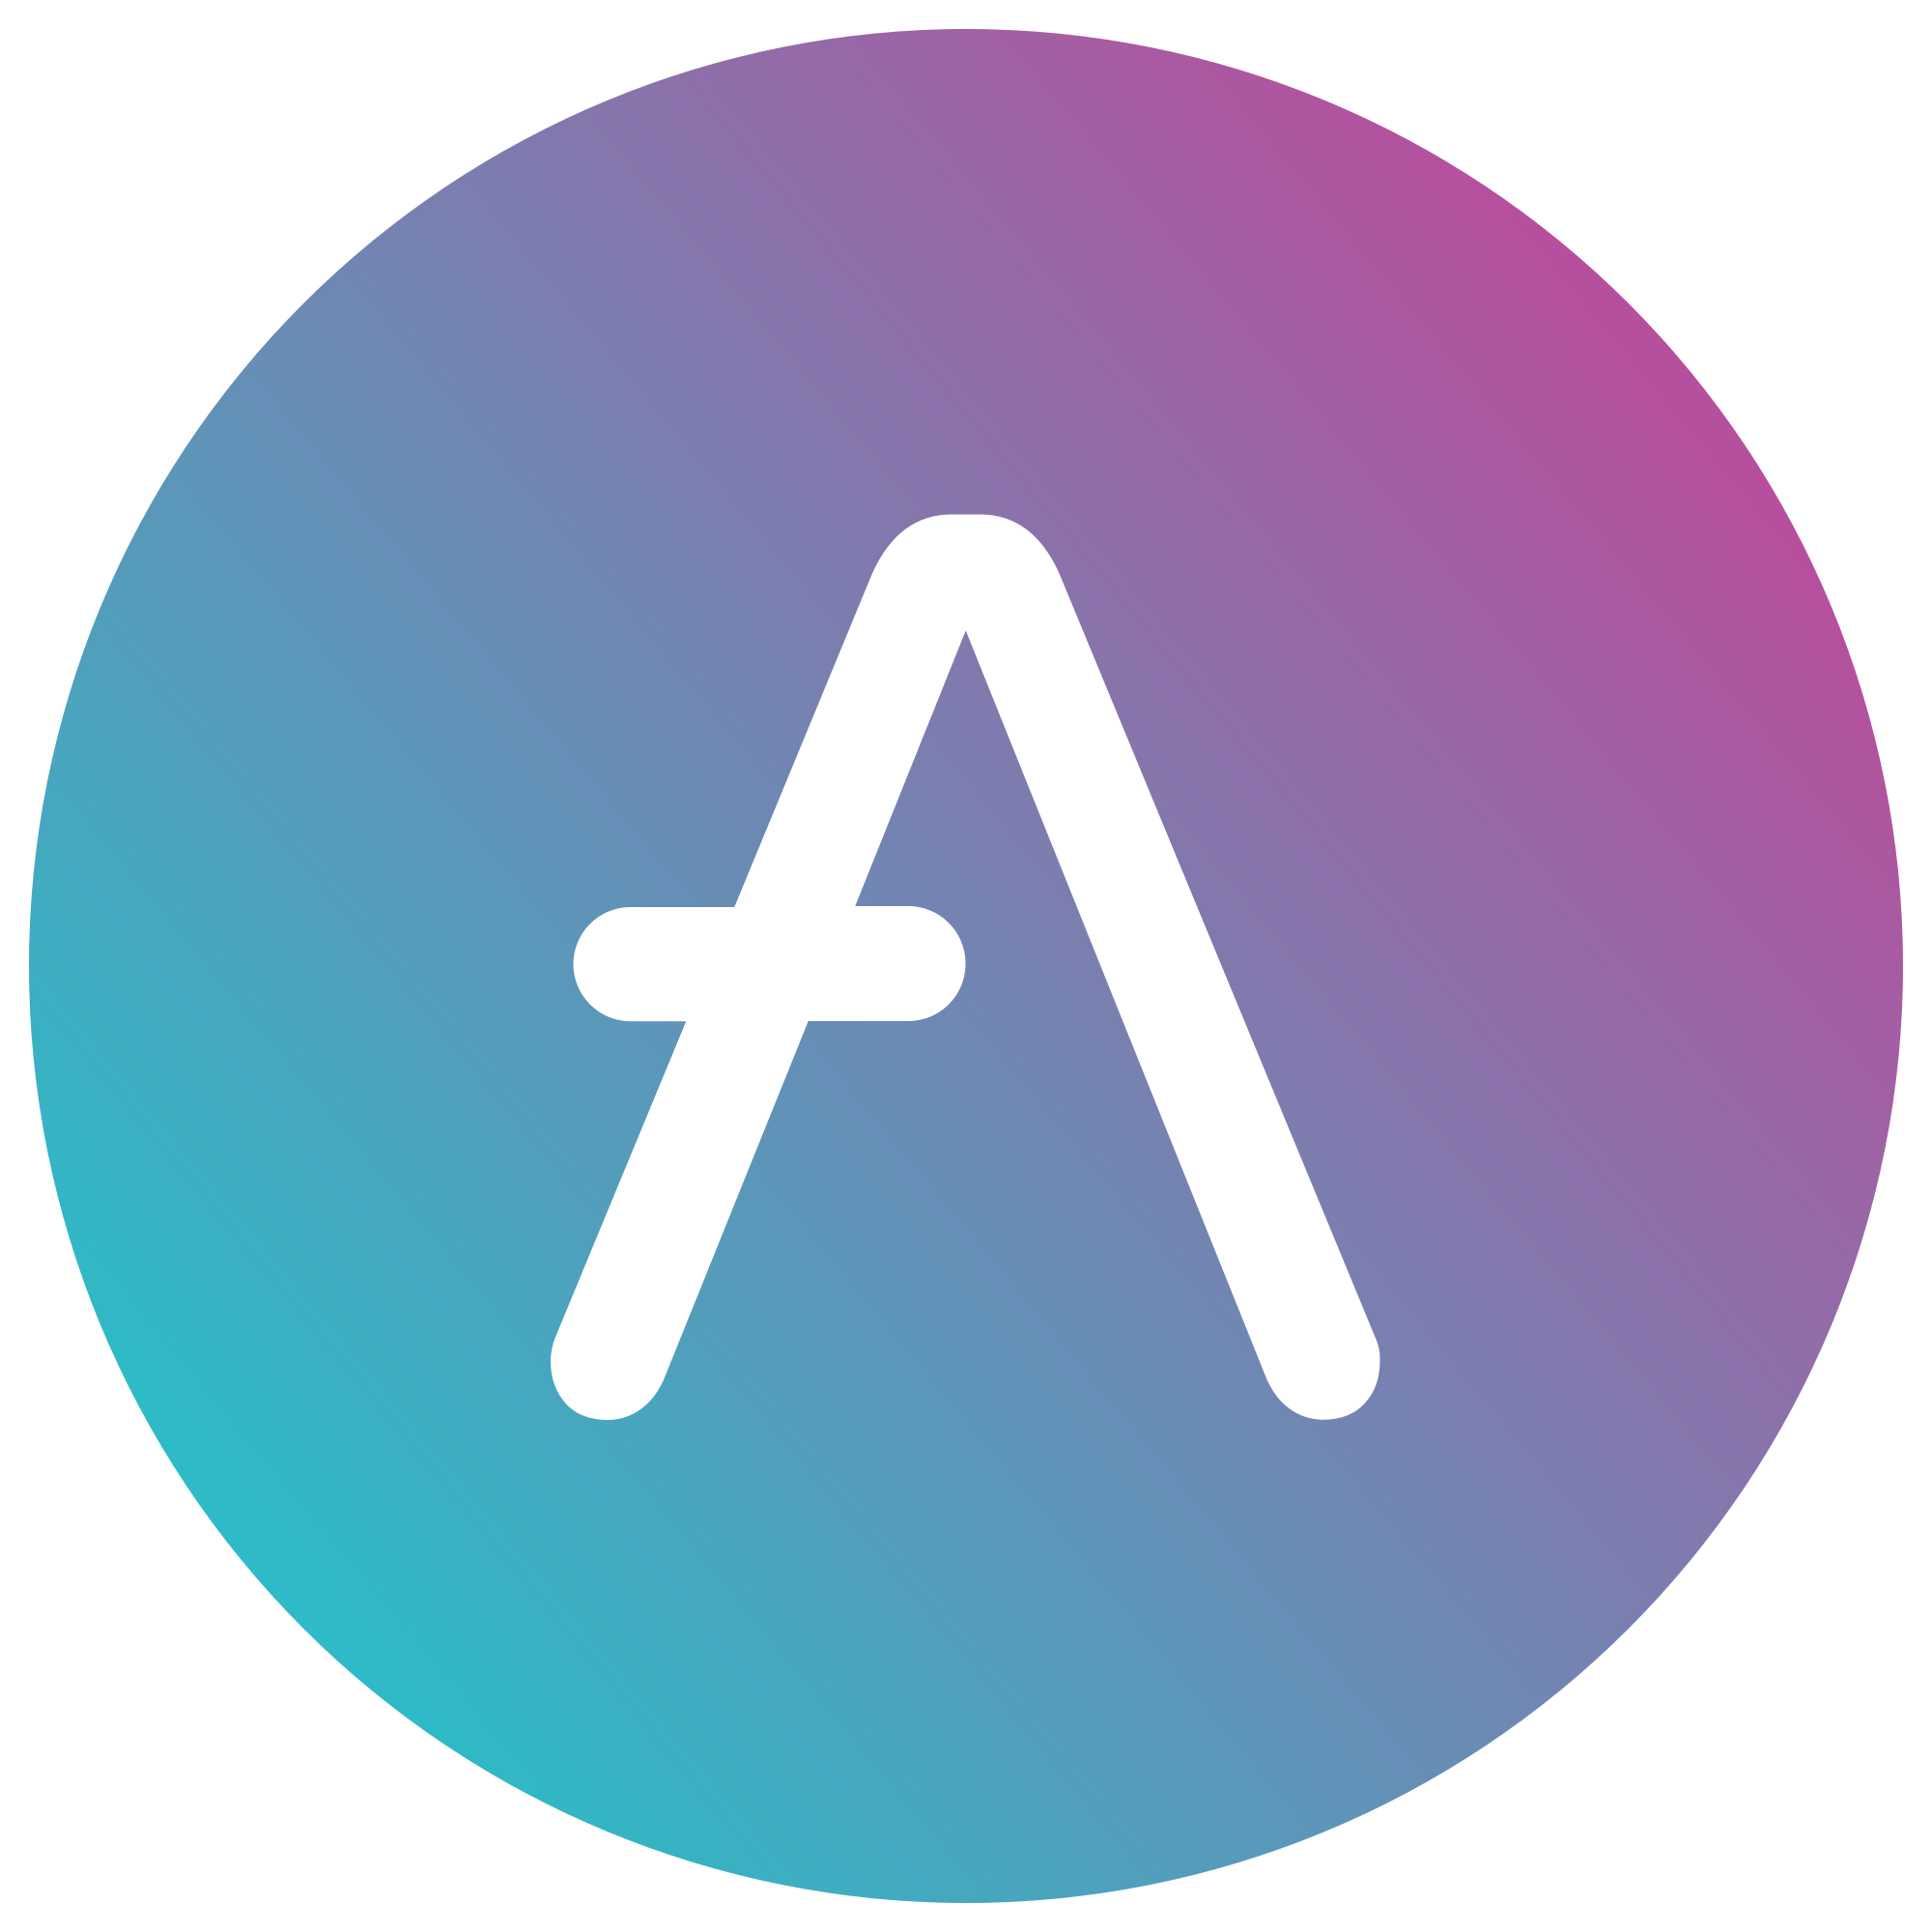

In [18]:
# current DAI lending pool ID in DWH
l_address_protocol_category_chain_id = 1

In [19]:
pit_token_symbol = 'DAI'

In [20]:
h_protocol_category = 'Lending'

In [23]:
query = f'''
    SELECT
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_lending_pool_overview.pit_token_symbol,
        pit_lending_pool_overview.pit_token_reserve_size * pit_lending_pool_overview.pit_token_price as usd_reserve_size,
        pit_lending_pool_overview.pit_token_borrow_size * pit_lending_pool_overview.pit_token_price as usd_borrow_size,
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        )
    FROM pit_lending_pool_overview
    LEFT JOIN l_addresses_protocols_categories_chains USING(l_address_protocol_category_chain_id)
    LEFT JOIN l_addresses_chains USING(l_address_chain_id)
    LEFT JOIN l_protocols_categories_chains USING(l_protocol_category_chain_id)
    LEFT JOIN l_protocols_categories USING(l_protocol_category_id)
    LEFT JOIN h_protocols USING(h_protocol_id)
    LEFT JOIN h_protocols_categories USING(h_protocol_category_id)
    LEFT JOIN h_chains ON l_addresses_chains.h_chain_id = h_chains.h_chain_id
    WHERE
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id = {l_address_protocol_category_chain_id} AND
        h_protocols_categories.h_protocol_category_name = '{h_protocol_category}' AND
        pit_lending_pool_overview.pit_token_symbol = '{pit_token_symbol}'
    GROUP BY
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id,
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        ),
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_lending_pool_overview.pit_token_symbol,
        pit_lending_pool_overview.pit_token_reserve_size,
        pit_lending_pool_overview.pit_token_borrow_size,
        pit_lending_pool_overview.pit_token_price
    ORDER BY 
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        ),
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id
'''

In [24]:
df = spark.read\
    .format("jdbc")\
    .option("url", f"jdbc:postgresql://{db_address}/{db_name}")\
    .option("dbtable", f'({query}) as _')\
    .option("user", db_user)\
    .option("password", db_password)\
    .option("driver", "org.postgresql.Driver")\
    .load()

In [25]:
df.toPandas().head()

,l_address_chain_name,h_protocol_name,h_network_name,pit_token_symbol,usd_reserve_size,usd_borrow_size,date_trunc
0,Lending Pool,Aave,eth,DAI,213008081.299,78228687.281,2022-10-07 01:17:00
1,Lending Pool,Aave,eth,DAI,213008090.936,78228697.299,2022-10-07 01:20:00
2,Lending Pool,Aave,eth,DAI,213008224.295,78228711.212,2022-10-07 01:25:00
3,Lending Pool,Aave,eth,DAI,213008237.680,78228725.125,2022-10-07 01:30:00
4,Lending Pool,Aave,eth,DAI,213008251.064,78228739.039,2022-10-07 01:35:00


In [29]:
go.Figure(
    data=[
        go.Bar(
            name="usd_reserve_size",
            x=df.toPandas()["date_trunc"],
            y=df.toPandas()["usd_reserve_size"],
            offsetgroup=0,
        ),
        go.Bar(
            name="usd_borrow_size",
            x=df.toPandas()["date_trunc"],
            y=df.toPandas()["usd_borrow_size"],
            offsetgroup=0,
        )
    ],
    layout=go.Layout(
        title="DAI Lending Pool Overview",
        yaxis_title="Size",
        xaxis_title='Date'
    )
)

> This plot illustrates the dynamic of the pool over a time period

On the **time interval**, you can observe a *change in the number of the total available and borrow reserves in the pool*

If there is not enough available liquidtiy in the pool it's becomes impossible to withdraw deposited assets

In [30]:
query = f'''
    SELECT
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_lending_pool_overview.pit_token_symbol,
        pit_lending_pool_overview.pit_token_reserve_size * pit_lending_pool_overview.pit_token_price as usd_reserve_size,
        pit_lending_pool_overview.pit_token_borrow_size * pit_lending_pool_overview.pit_token_price as usd_borrow_size,
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        )
    FROM pit_lending_pool_overview
    LEFT JOIN l_addresses_protocols_categories_chains USING(l_address_protocol_category_chain_id)
    LEFT JOIN l_addresses_chains USING(l_address_chain_id)
    LEFT JOIN l_protocols_categories_chains USING(l_protocol_category_chain_id)
    LEFT JOIN l_protocols_categories USING(l_protocol_category_id)
    LEFT JOIN h_protocols USING(h_protocol_id)
    LEFT JOIN h_protocols_categories USING(h_protocol_category_id)
    LEFT JOIN h_chains ON l_addresses_chains.h_chain_id = h_chains.h_chain_id
    WHERE
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id = {l_address_protocol_category_chain_id} AND
        h_protocols_categories.h_protocol_category_name = '{h_protocol_category}' AND
        pit_lending_pool_overview.pit_token_symbol = '{pit_token_symbol}'
    GROUP BY
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id,
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        ),
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_lending_pool_overview.pit_token_symbol,
        pit_lending_pool_overview.pit_token_reserve_size,
        pit_lending_pool_overview.pit_token_borrow_size,
        pit_lending_pool_overview.pit_token_price
    ORDER BY 
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        ),
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id
    LIMIT(
        SELECT 
            COUNT(DISTINCT pit_lending_pool_overview.pit_token_symbol)
        FROM pit_lending_pool_overview
        LEFT JOIN l_addresses_protocols_categories_chains USING(l_address_protocol_category_chain_id)
        LEFT JOIN l_protocols_categories_chains USING(l_protocol_category_chain_id)
        LEFT JOIN l_protocols_categories USING(l_protocol_category_id)
        LEFT JOIN h_protocols_categories USING(h_protocol_category_id)
        WHERE 
            l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id = {l_address_protocol_category_chain_id} AND
            h_protocols_categories.h_protocol_category_name = '{h_protocol_category}' AND
            pit_lending_pool_overview.pit_token_symbol = '{pit_token_symbol}'
        )
'''

In [31]:
df = spark.read\
    .format("jdbc")\
    .option("url", f"jdbc:postgresql://{db_address}/{db_name}")\
    .option("dbtable", f'({query}) as _')\
    .option("user", db_user)\
    .option("password", db_password)\
    .option("driver", "org.postgresql.Driver")\
    .load()

In [33]:
df.toPandas().head()

,l_address_chain_name,h_protocol_name,h_network_name,pit_token_symbol,usd_reserve_size,usd_borrow_size,date_trunc
0,Lending Pool,Aave,eth,DAI,213008081.299,78228687.281,2022-10-07 01:17:00


In [39]:
df = df.selectExpr(
        """
            STACK(
                2, 
                'reserve', usd_reserve_size, 
                'borrow', usd_borrow_size
            ) as (type, size)
        """
)

In [40]:
df.toPandas().head()

,type,size
0,reserve,213008081.299
1,borrow,78228687.281


In [42]:
px.pie(
    df.toPandas(), 
    values='size', 
    hole=0.4,
    names='type',
    title = 'DAI Lending Pool Overview',
)

> The same plot as the previous one, but illustrates the current composition of the pool

In [47]:
query = f'''
    SELECT
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_lending_pool_overview.pit_token_symbol,
        pit_lending_pool_overview.pit_token_reserve_size * pit_lending_pool_overview.pit_token_price + pit_lending_pool_overview.pit_token_borrow_size * pit_lending_pool_overview.pit_token_price as tvl,
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        )
    FROM pit_lending_pool_overview
    LEFT JOIN l_addresses_protocols_categories_chains USING(l_address_protocol_category_chain_id)
    LEFT JOIN l_addresses_chains USING(l_address_chain_id)
    LEFT JOIN l_protocols_categories_chains USING(l_protocol_category_chain_id)
    LEFT JOIN l_protocols_categories USING(l_protocol_category_id)
    LEFT JOIN h_protocols USING(h_protocol_id)
    LEFT JOIN h_protocols_categories USING(h_protocol_category_id)
    LEFT JOIN h_chains ON l_addresses_chains.h_chain_id = h_chains.h_chain_id
    WHERE
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id = {l_address_protocol_category_chain_id} AND
        h_protocols_categories.h_protocol_category_name = '{h_protocol_category}' AND
        pit_lending_pool_overview.pit_token_symbol = '{pit_token_symbol}'
    GROUP BY
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id,
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        ),
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_lending_pool_overview.pit_token_symbol,
        pit_lending_pool_overview.pit_token_reserve_size,
        pit_lending_pool_overview.pit_token_borrow_size,
        pit_lending_pool_overview.pit_token_price
    ORDER BY 
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        ),
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id
'''

In [48]:
df = spark.read\
    .format("jdbc")\
    .option("url", f"jdbc:postgresql://{db_address}/{db_name}")\
    .option("dbtable", f'({query}) as _')\
    .option("user", db_user)\
    .option("password", db_password)\
    .option("driver", "org.postgresql.Driver")\
    .load()

In [49]:
df.toPandas().head()

,l_address_chain_name,h_protocol_name,h_network_name,pit_token_symbol,tvl,date_trunc
0,Lending Pool,Aave,eth,DAI,291236768.580,2022-10-07 01:17:00
1,Lending Pool,Aave,eth,DAI,291236788.234,2022-10-07 01:20:00
2,Lending Pool,Aave,eth,DAI,291236935.507,2022-10-07 01:25:00
3,Lending Pool,Aave,eth,DAI,291236962.805,2022-10-07 01:30:00
4,Lending Pool,Aave,eth,DAI,291236990.103,2022-10-07 01:35:00


In [50]:
px.line(
    df.toPandas(), 
    x="date_trunc", 
    y="tvl", 
    title='DAI Lending Pool TVL'
)

On this plot may observe a change in **TVL** over time, sudden changes can serve as an indicator of the corresponding market reaction to certain events

In [72]:
query = f'''
    SELECT
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_lending_pool_overview.pit_token_symbol,
        pit_lending_pool_overview.pit_token_borrow_size * pit_lending_pool_overview.pit_token_price / (pit_lending_pool_overview.pit_token_reserve_size * pit_lending_pool_overview.pit_token_price) as utilization_ratio,
        pit_lending_pool_overview.pit_token_deposit_apy / 100 as pit_token_deposit_apy,
        pit_lending_pool_overview.pit_token_borrow_apy / 100 as pit_token_borrow_apy,
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        )
    FROM pit_lending_pool_overview
    LEFT JOIN l_addresses_protocols_categories_chains USING(l_address_protocol_category_chain_id)
    LEFT JOIN l_addresses_chains USING(l_address_chain_id)
    LEFT JOIN l_protocols_categories_chains USING(l_protocol_category_chain_id)
    LEFT JOIN l_protocols_categories USING(l_protocol_category_id)
    LEFT JOIN h_protocols USING(h_protocol_id)
    LEFT JOIN h_protocols_categories USING(h_protocol_category_id)
    LEFT JOIN h_chains ON l_addresses_chains.h_chain_id = h_chains.h_chain_id
    WHERE
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id = {l_address_protocol_category_chain_id} AND
        h_protocols_categories.h_protocol_category_name = '{h_protocol_category}' AND
        pit_lending_pool_overview.pit_token_symbol = '{pit_token_symbol}'
    GROUP BY
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id,
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        ),
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_lending_pool_overview.pit_token_symbol,
        pit_lending_pool_overview.pit_token_reserve_size,
        pit_lending_pool_overview.pit_token_borrow_size,
        pit_lending_pool_overview.pit_token_price,
        pit_lending_pool_overview.pit_token_deposit_apy,
        pit_lending_pool_overview.pit_token_borrow_apy
    ORDER BY 
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        ),
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id
'''

In [73]:
df = spark.read\
    .format("jdbc")\
    .option("url", f"jdbc:postgresql://{db_address}/{db_name}")\
    .option("dbtable", f'({query}) as _')\
    .option("user", db_user)\
    .option("password", db_password)\
    .option("driver", "org.postgresql.Driver")\
    .load()

In [74]:
df.toPandas().head()

,l_address_chain_name,h_protocol_name,h_network_name,pit_token_symbol,utilization_ratio,pit_token_deposit_apy,pit_token_borrow_apy,date_trunc
0,Lending Pool,Aave,eth,DAI,0.367,0.007,0.019,2022-10-07 01:17:00
1,Lending Pool,Aave,eth,DAI,0.367,0.007,0.019,2022-10-07 01:20:00
2,Lending Pool,Aave,eth,DAI,0.367,0.007,0.019,2022-10-07 01:25:00
3,Lending Pool,Aave,eth,DAI,0.367,0.007,0.019,2022-10-07 01:30:00
4,Lending Pool,Aave,eth,DAI,0.367,0.007,0.019,2022-10-07 01:35:00


In [75]:
go.Figure(
    data=[
        go.Scatter(
            name="utilization_ratio",
            x=df.toPandas()["date_trunc"],
            y=df.toPandas()["utilization_ratio"] * 100
        ),
        go.Scatter(
            name="deposit_apy",
            x=df.toPandas()["date_trunc"],
            y=df.toPandas()["pit_token_deposit_apy"] * 100
        ),
        go.Scatter(
            name="borrow_apy",
            x=df.toPandas()["date_trunc"],
            y=df.toPandas()["pit_token_borrow_apy"] * 100
        )
    ],
    layout=go.Layout(
        title="DAI Lending Pool Overview",
        yaxis_title="%",
        xaxis_title='Date'
    )
)

This plot may observe a change in UR, Deposit and Borrow APY over time

> **Utilization ratio** is the amount of revolving credit you're currently using divided by the total amount of revolving credit you have available. In other words, it's how much you currently owe divided by your credit limit. It is generally expressed as a percent

> **APY** indicates the total amount of interest you earn on a deposit/borrow account over one year, assuming you do not add or withdraw funds for the entire year. The annual percentage yield is expressed as an annualized rate. APY includes your interest rate and the frequency of compounding interest, which is the interest you earn on your principal plus the interest on your earnings

In [68]:
query = f'''
    SELECT
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_lending_pool_overview.pit_token_symbol,
        pit_lending_pool_overview.pit_token_price,
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        )
    FROM pit_lending_pool_overview
    LEFT JOIN l_addresses_protocols_categories_chains USING(l_address_protocol_category_chain_id)
    LEFT JOIN l_addresses_chains USING(l_address_chain_id)
    LEFT JOIN l_protocols_categories_chains USING(l_protocol_category_chain_id)
    LEFT JOIN l_protocols_categories USING(l_protocol_category_id)
    LEFT JOIN h_protocols USING(h_protocol_id)
    LEFT JOIN h_protocols_categories USING(h_protocol_category_id)
    LEFT JOIN h_chains ON l_addresses_chains.h_chain_id = h_chains.h_chain_id
    WHERE
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id = {l_address_protocol_category_chain_id} AND
        h_protocols_categories.h_protocol_category_name = '{h_protocol_category}' AND
        pit_lending_pool_overview.pit_token_symbol = '{pit_token_symbol}'
    GROUP BY
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id,
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        ),
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_lending_pool_overview.pit_token_symbol,
        pit_lending_pool_overview.pit_token_reserve_size,
        pit_lending_pool_overview.pit_token_borrow_size,
        pit_lending_pool_overview.pit_token_price,
        pit_lending_pool_overview.pit_token_deposit_apy,
        pit_lending_pool_overview.pit_token_borrow_apy
    ORDER BY 
        DATE_TRUNC(
            'minute', 
            pit_lending_pool_overview.pit_lending_pool_overview_load_ts
        ),
        l_addresses_protocols_categories_chains.l_address_protocol_category_chain_id
'''

In [69]:
df = spark.read\
    .format("jdbc")\
    .option("url", f"jdbc:postgresql://{db_address}/{db_name}")\
    .option("dbtable", f'({query}) as _')\
    .option("user", db_user)\
    .option("password", db_password)\
    .option("driver", "org.postgresql.Driver")\
    .load()

In [70]:
df.toPandas().head()

,l_address_chain_name,h_protocol_name,h_network_name,pit_token_symbol,pit_token_price,date_trunc
0,Lending Pool,Aave,eth,DAI,1.000,2022-10-07 01:17:00
1,Lending Pool,Aave,eth,DAI,1.000,2022-10-07 01:20:00
2,Lending Pool,Aave,eth,DAI,1.000,2022-10-07 01:25:00
3,Lending Pool,Aave,eth,DAI,1.000,2022-10-07 01:30:00
4,Lending Pool,Aave,eth,DAI,1.000,2022-10-07 01:35:00


In [71]:
px.line(
    df.toPandas(), 
    x="date_trunc", 
    y="pit_token_price", 
    color='pit_token_symbol',
    title='DAI Lending Pool Token Price'
)

**DAI** is the stablecoin so the price fluctuates around $1